In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

In [2]:
H = 100
W = 100
h = H-1
w = W-1

n_min = 2
n_max = 6

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.40202926 0.875      0.13322032 0.115     ]
 [0.73265408 0.625      0.11185561 0.15874492]
 [0.36484609 0.375      0.13915342 0.23647031]
 [0.47517425 0.125      0.12871986 0.12871986]]
[0. 0. 0. 2.]


In [4]:
anchor_boxes = np.array([
    [0.5,0.5],
    [0.5,0.25],
    [0.25,0.5],
    [0.25,0.25],
    [0.25,0.125],
    [0.125,0.25],
    [0.125,0.125]
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

W0807 14:43:32.663795 140191974754048 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


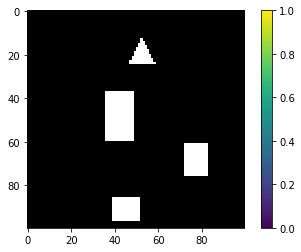

In [5]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [6]:
print(anchors_1d.shape)
print(gt_box.shape)
gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)

print(gt_t.shape)
print(gt_matched.shape)
print(gt_labels.shape)
print(gt_weights.shape)

(70000, 4)
(4, 4)
(70000, 4)
(70000, 4)
(70000,)
(70000,)


In [7]:
np.sum(gt_weights)

67977.0